# Random Forest RandomSearchCV
Aggregated Invoice Data (Mean Consumption) - Balanced Data - Dummies

```
As of 2025-05-12 11:40 

 Model performance for

 Random Forest RandomSearchCV - Aggregated Invoice Data (Mean Consumption) - Dummies - Balanced Data:

---------------
* Test Data F1 Score:  0.1578
* Test Data ROC AUC:   0.6406
* Test Data MCC:       0.1334
* Test Data Accuracy:  0.4834
* Test Data Precision: 0.0873
```

In [ ]:
# Used for filename when saving model
model_ref = "rf_rscv_agg_mean_dummies_balanced"

# Used for graph titles
#model_name = "randomforest RandomSearchCV agg-data v1"
model_name = "Random Forest RandomSearchCV"
model_details = "Aggregated Invoice Data (Mean Consumption) - Dummies - Balanced Data"

In [1]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

In [ ]:
# Reload model from file if needed


saved_model_filename = "rf_rscv_agg_mean_dummies_balanced_2025-05-12_112358.skops"

unknown_types = get_untrusted_types(file=f"models/{saved_model_filename}")
# investigate the contents of unknown_types, and only load if you trust
# everything you see.
best_model = load(f"models/{saved_model_filename}", trusted=unknown_types)



## Run data cleaning script, generate parquet files. 
Requires pyarrow and fastparquet (see requirements.txt)

In [8]:
# Open and run **ETL_export_parquet_invoice-level_+_client-level_mean.py**

## Import parquet files

In [3]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarised. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_agg.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

In [10]:
df_train_non_agg

,creation_date,target,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type_ELEC,counter_type_GAZ,...,counter_code_450,counter_code_453,counter_code_467,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65
0,34699,0,1.0,82.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
1,34699,0,1.0,1200.0,184.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
2,34699,0,1.0,123.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
3,34699,0,1.0,102.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
4,34699,0,1.0,572.0,0.0,0.0,0.0,12,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430783,40869,0,1.0,118.0,0.0,0.0,0.0,4,False,True,...,False,False,False,False,True,False,False,False,False,False
4430784,40869,0,1.0,312.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
4430785,40869,0,1.0,578.0,0.0,0.0,0.0,4,True,False,...,False,False,False,False,False,False,False,False,False,False
4430786,34325,0,1.0,400.0,135.0,0.0,0.0,8,True,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# Choose dataset to use in this document
df = df_train_agg
df_final_test = df_final_test_agg

In [12]:
df.head()

,creation_date,target,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC,...,counter_code_450,counter_code_453,counter_code_467,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65
0,34699,0,35,1.0,352.400000,10.571429,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
1,37405,0,37,1.0,557.540541,0.000000,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
2,31484,0,18,1.0,798.611111,37.888889,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
3,35257,0,20,1.0,1.200000,0.000000,0.000000,0.000000,False,True,...,False,False,False,False,False,False,False,False,False,False
4,41926,0,14,1.0,663.714286,104.857143,117.357143,36.714286,False,True,...,False,False,False,False,False,False,False,False,False,False


In [13]:
df.describe()

,creation_date,target,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,reading_remarque,counter_statue
count,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000,128000.000000
mean,37801.779602,0.059078,34.615531,1.001211,407.277247,117.619880,27.496823,75.918575,8.781734,0.010695
std,4107.568660,0.235772,25.782890,0.183005,342.787037,756.054243,96.626119,833.338704,0.726306,0.160331
min,28161.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,34858.000000,0.000000,13.000000,1.000000,220.530312,0.000000,0.000000,0.000000,9.000000,0.000000
50%,39018.500000,0.000000,31.500000,1.000000,355.161002,6.892857,0.000000,0.000000,9.000000,0.000000
75%,41108.000000,0.000000,52.000000,1.000000,533.078947,66.688702,5.560244,0.000000,9.000000,0.000000
max,43718.000000,1.000000,434.000000,40.000000,34024.000000,115683.000000,2400.000000,79179.777778,9.000000,5.000000


## Split Data to Train and Test

In [5]:
# Make sure final_test has same dummy columns in as training data (filled with False)
def add_missing_dummy_columns_and_fill_false(train, final_test): 

    cols_missing_from_final_test = (set(train) - set(final_test)) - set(['target'])

    for cols in cols_missing_from_final_test:   
        final_test[cols] = False
    print(f"Adding new cols to final_test: {cols_missing_from_final_test}")

add_missing_dummy_columns_and_fill_false(df, df_final_test)

Adding new cols to final_test: {'counter_code_307', 'counter_code_305', 'region_199'}


In [6]:
X = df.loc[:, ~df.columns.isin(["target"])]
y = df["target"]
X_final_test = df_final_test

# make sure column order the same in X and X_final_test
X, X_final_test = X.align(X_final_test, join="right", axis=1)

RSEED = 42

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RSEED
)


### Balance Classes

In [7]:

## Balance classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

## Imputing missing values

In [23]:
# % of missing values for each column in Training data
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

creation_date       0.0
tarif_type_11       0.0
counter_code_214    0.0
counter_code_210    0.0
counter_code_207    0.0
                   ... 
region_302          0.0
region_301          0.0
region_206          0.0
region_199          0.0
counter_code_65     0.0
Length: 89, dtype: float64

In [24]:
# % of missing values for each column in the final test data. Compare with training data above to see if similar proportion.
(100 * df_final_test.isnull().sum() / df_final_test.count()).sort_values(ascending=False)

creation_date         0.0
transactions_count    0.0
counter_code_222      0.0
counter_code_214      0.0
counter_code_210      0.0
                     ... 
region_303            0.0
region_302            0.0
region_301            0.0
region_206            0.0
counter_code_307      0.0
Length: 88, dtype: float64

In [25]:
# What does the data look like for rows with missing data
df_missing_values = df[pd.isnull(df["transactions_count"]) == True]

In [26]:
X_train_resampled

,creation_date,transactions_count,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type_GAZ,counter_type_ELEC,reading_remarque,...,counter_code_483,counter_code_5,counter_code_506,counter_code_532,counter_code_565,counter_code_600,counter_code_65,region_199,counter_code_305,counter_code_307
0,38240,22,1.0,403.363636,0.000000,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
1,36136,26,1.0,964.730769,0.000000,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
2,28458,30,1.0,2598.300000,91.000000,0.000000,0.000000,False,True,8,...,False,False,False,False,False,False,False,False,False,False
3,40522,4,1.0,1339.750000,174.500000,0.000000,0.000000,False,True,8,...,False,False,False,False,False,False,False,False,False,False
4,39233,63,1.0,159.301587,0.000000,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168609,30404,53,1.0,762.905660,141.358491,9.528302,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
168610,39801,52,1.0,246.442308,5.442308,0.000000,0.000000,True,True,9,...,False,False,False,False,False,False,False,False,False,False
168611,31201,26,1.0,639.000000,352.076923,30.769231,84.846154,True,True,9,...,False,False,False,False,False,False,False,False,False,False
168612,32976,40,1.0,314.300000,30.725000,16.550000,0.000000,True,True,9,...,False,True,False,False,False,False,False,False,False,False


In [27]:
y_train_resampled.value_counts()

target
0    84307
1    84307
Name: count, dtype: int64

In [ ]:
# pipeline

# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(X_train_resampled.columns[X_train_resampled.dtypes==object])

num_features = list(X_train_resampled.columns[X_train_resampled.dtypes!=object])

from sklearn.pipeline import Pipeline

# Pipeline for numeric features 
num_transformer = Pipeline([
    ('imputer_num', SimpleImputer(missing_values=0, strategy='mean')), # replace 0 with means 
   # ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_transformer = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
],
    n_jobs=8)

# Train Model

In [ ]:
param_dist = {
    'classifier__n_estimators': np.arange(10, 201).astype(int),
    'classifier__max_depth': [None] + list(np.arange(3, 21).astype(int)),
    'classifier__max_features': ['sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}
param_dist2 = {
    'classifier__n_estimators': np.arange(10, 201).astype(int),
    'classifier__max_depth': list(np.arange(3, 21).astype(int)),
    'classifier__max_features': ['sqrt'] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': list(np.arange(10, 51).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

# Estimator for use in random search
#estimator = RandomForestClassifier(random_state = RSEED)

# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = RSEED, n_jobs=8))
])

random_search = RandomizedSearchCV(
    pipe, param_dist2, 
    n_iter=50, #100
    cv=5, 
    scoring="f1", verbose=3, n_jobs=8
)
random_search.fit(X_train_resampled, y_train_resampled)

print(f"Best F1 score: {random_search.best_score_}")


# Save best model for future use

# https://scikit-learn.org/stable/model_persistence.html#skops-persistence

best_model = random_search.best_estimator_

timestamp_for_filename = time.strftime("%Y-%m %d_%H%M%S")

filepath = f"./models/{model_name} {timestamp_for_filename}.skops"

obj = dump(best_model, filepath)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.7, classifier__max_leaf_nodes=48, classifier__min_samples_split=2, classifier__n_estimators=68;, score=0.697 total time= 1.1min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.7, classifier__max_leaf_nodes=48, classifier__min_samples_split=2, classifier__n_estimators=68;, score=0.701 total time= 1.2min
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.7, classifier__max_leaf_nodes=48, classifier__min_samples_split=2, classifier__n_estimators=68;, score=0.698 total time= 1.3min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.7, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=153;, score=0.698 total time= 1.5min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.7, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=153;, score=0.698 total time= 1.5min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.7, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=153;, score=0.694 total time= 1.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.7, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=153;, score=0.702 total time= 1.6min
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.7, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=153;, score=0.698 total time= 1.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:

[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.7, classifier__max_leaf_nodes=48, classifier__min_samples_split=2, classifier__n_estimators=68;, score=0.701 total time=  58.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.7, classifier__max_leaf_nodes=48, classifier__min_samples_split=2, classifier__n_estimators=68;, score=0.705 total time= 1.1min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.6, classifier__max_leaf_nodes=30, classifier__min_samples_split=5, classifier__n_estimators=44;, score=0.693 total time=  55.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.6, classifier__max_leaf_nodes=30, classifier__min_samples_split=5, classifier__n_estimators=44;, score=0.688 total time=  48.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=37, classifier__min_samples_split=5, classifier__n_estimators=162;, score=0.693 total time= 1.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.6, classifier__max_leaf_nodes=30, classifier__min_samples_split=5, classifier__n_estimators=44;, score=0.687 total time=  55.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=37, classifier__min_samples_split=5, classifier__n_estimators=162;, score=0.690 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=37, classifier__min_samples_split=5, classifier__n_estimators=162;, score=0.692 total time= 1.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.6, classifier__max_leaf_nodes=30, classifier__min_samples_split=5, classifier__n_estimators=44;, score=0.686 total time=  50.6s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=37, classifier__min_samples_split=5, classifier__n_estimators=162;, score=0.693 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635

[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=37, classifier__min_samples_split=5, classifier__n_estimators=162;, score=0.698 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.6, classifier__max_leaf_nodes=30, classifier__min_samples_split=5, classifier__n_estimators=44;, score=0.691 total time=  39.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=18;, score=0.697 total time=  25.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=18;, score=0.696 total time=  27.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=18;, score=0.694 total time=  27.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=18;, score=0.691 total time=  29.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=18;, score=0.702 total time=  26.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=sqrt, classifier__max_leaf_nodes=46, classifier__min_samples_split=5, classifier__n_estimators=176;, score=0.696 total time=  47.1s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=sqrt, classifier__max_leaf_nodes=46, classifier__min_samples_split=5, classifier__n_estimators=176;, score=0.675 total time=  41.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=sqrt, classifier__max_leaf_nodes=46, classifier__min_samples_split=5, classifier__n_estimators=176;, score=0.693 total time=  39.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=sqrt, classifier__max_leaf_nodes=46, classifier__min_samples_split=5, classifier__n_estimators=176;, score=0.701 total time=  49.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=sqrt, classifier__max_leaf_nodes=46, classifier__min_samples_split=5, classifier__n_estimators=176;, score=0.687 total time=  42.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=38, classifier__min_samples_split=2, classifier__n_estimators=142;, score=0.689 total time= 2.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=38, classifier__min_samples_split=2, classifier__n_estimators=142;, score=0.692 total time= 2.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=38, classifier__min_samples_split=2, classifier__n_estimators=142;, score=0.698 total time= 2.8min
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=38, classifier__min_samples_split=2, classifier__n_estimators=142;, score=0.696 total time= 2.7min
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=21, classifier__min_samples_split=2, classifier__n_estimators=93;, score=0.686 total time= 1.0min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=38, classifier__min_samples_split=2, classifier__n_estimators=142;, score=0.695 total time= 2.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=21, classifier__min_samples_split=2, classifier__n_estimators=93;, score=0.699 total time=  56.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=21, classifier__min_samples_split=2, classifier__n_estimators=93;, score=0.696 total time=  54.1s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=21, classifier__min_samples_split=2, classifier__n_estimators=93;, score=0.697 total time=  55.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=20, classifier__min_samples_split=5, classifier__n_estimators=45;, score=0.685 total time=  37.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=20, classifier__min_samples_split=5, classifier__n_estimators=45;, score=0.682 total time=  37.3s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=20, classifier__min_samples_split=5, classifier__n_estimators=45;, score=0.684 total time=  37.2s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=20, classifier__min_samples_split=5, classifier__n_estimators=45;, score=0.675 total time=  36.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635

[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=21, classifier__min_samples_split=2, classifier__n_estimators=93;, score=0.698 total time=  44.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=20, classifier__min_samples_split=5, classifier__n_estimators=45;, score=0.680 total time=  23.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=55;, score=0.689 total time=  41.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=55;, score=0.687 total time=  45.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=55;, score=0.688 total time=  45.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=55;, score=0.689 total time=  45.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=27, classifier__min_samples_split=2, classifier__n_estimators=88;, score=0.691 total time=  46.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=55;, score=0.680 total time=  45.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=27, classifier__min_samples_split=2, classifier__n_estimators=88;, score=0.691 total time=  43.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=27, classifier__min_samples_split=2, classifier__n_estimators=88;, score=0.693 total time=  43.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=5, classifier__n_estimators=157;, score=0.691 total time= 2.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=5, classifier__n_estimators=157;, score=0.682 total time= 2.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=27, classifier__min_samples_split=2, classifier__n_estimators=88;, score=0.694 total time=  45.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=5, classifier__n_estimators=157;, score=0.685 total time= 2.6min
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=5, classifier__n_estimators=157;, score=0.682 total time= 2.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:

[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=5, classifier__n_estimators=157;, score=0.687 total time= 2.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.5, classifier__max_leaf_nodes=27, classifier__min_samples_split=2, classifier__n_estimators=88;, score=0.695 total time=  35.6s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.6, classifier__max_leaf_nodes=23, classifier__min_samples_split=2, classifier__n_estimators=53;, score=0.688 total time=  30.3s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.6, classifier__max_leaf_nodes=23, classifier__min_samples_split=2, classifier__n_estimators=53;, score=0.687 total time=  29.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.6, classifier__max_leaf_nodes=23, classifier__min_samples_split=2, classifier__n_estimators=53;, score=0.688 total time=  29.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.6, classifier__max_leaf_nodes=23, classifier__min_samples_split=2, classifier__n_estimators=53;, score=0.691 total time=  29.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=0.6, classifier__max_leaf_nodes=23, classifier__min_samples_split=2, classifier__n_estimators=53;, score=0.692 total time=  29.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=42, classifier__min_samples_split=10, classifier__n_estimators=48;, score=0.692 total time=  46.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=42, classifier__min_samples_split=10, classifier__n_estimators=48;, score=0.695 total time=  47.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=42, classifier__min_samples_split=10, classifier__n_estimators=48;, score=0.693 total time=  49.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=0.5, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=159;, score=0.692 total time= 1.4min
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=0.5, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=159;, score=0.691 total time= 1.4min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=0.5, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=159;, score=0.692 total time= 1.4min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=0.5, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=159;, score=0.694 total time= 1.5min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=42, classifier__min_samples_split=10, classifier__n_estimators=48;, score=0.693 total time=  43.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=0.5, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=159;, score=0.691 total time= 1.5min
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=42, classifier__min_samples_split=10, classifier__n_estimators=48;, score=0.699 total time=  43.1s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.7, classifier__max_leaf_nodes=31, classifier__min_samples_split=10, classifier__n_estimators=112;, score=0.693 total time= 1.1min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.5, classifier__max_leaf_nodes=13, classifier__min_samples_split=10, classifier__n_estimators=86;, score=0.691 total time=  28.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.5, classifier__max_leaf_nodes=13, classifier__min_samples_split=10, classifier__n_estimators=86;, score=0.693 total time=  31.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.7, classifier__max_leaf_nodes=31, classifier__min_samples_split=10, classifier__n_estimators=112;, score=0.686 total time= 1.0min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.7, classifier__max_leaf_nodes=31, classifier__min_samples_split=10, classifier__n_estimators=112;, score=0.688 total time= 1.1min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.5, classifier__max_leaf_nodes=13, classifier__min_samples_split=10, classifier__n_estimators=86;, score=0.692 total time=  28.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.5, classifier__max_leaf_nodes=13, classifier__min_samples_split=10, classifier__n_estimators=86;, score=0.697 total time=  22.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.5, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=78;, score=0.703 total time=  20.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.5, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=78;, score=0.704 total time=  20.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.5, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=78;, score=0.705 total time=  16.9s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.7, classifier__max_leaf_nodes=31, classifier__min_samples_split=10, classifier__n_estimators=112;, score=0.694 total time= 1.0min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.5, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=78;, score=0.704 total time=  19.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.7, classifier__max_leaf_nodes=31, classifier__min_samples_split=10, classifier__n_estimators=112;, score=0.690 total time= 1.0min
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.5, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=78;, score=0.706 total time=  19.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=0.5, classifier__max_leaf_nodes=13, classifier__min_samples_split=10, classifier__n_estimators=86;, score=0.701 total time=  27.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=sqrt, classifier__max_leaf_nodes=47, classifier__min_samples_split=5, classifier__n_estimators=73;, score=0.681 total time=  14.5s
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=sqrt, classifier__max_leaf_nodes=47, classifier__min_samples_split=5, classifier__n_estimators=73;, score=0.673 total time=  12.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=sqrt, classifier__max_leaf_nodes=47, classifier__min_samples_split=5, classifier__n_estimators=73;, score=0.676 total time=  12.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=sqrt, classifier__max_leaf_nodes=47, classifier__min_samples_split=5, classifier__n_estimators=73;, score=0.679 total time=  14.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=5, classifier__max_features=sqrt, classifier__max_leaf_nodes=47, classifier__min_samples_split=5, classifier__n_estimators=73;, score=0.672 total time=  15.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.5, classifier__max_leaf_nodes=45, classifier__min_samples_split=5, classifier__n_estimators=129;, score=0.695 total time=  43.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.5, classifier__max_leaf_nodes=45, classifier__min_samples_split=5, classifier__n_estimators=129;, score=0.697 total time=  46.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=57;, score=0.689 total time=  41.6s
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.5, classifier__max_leaf_nodes=45, classifier__min_samples_split=5, classifier__n_estimators=129;, score=0.694 total time=  46.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.5, classifier__max_leaf_nodes=45, classifier__min_samples_split=5, classifier__n_estimators=129;, score=0.699 total time=  45.1s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=57;, score=0.686 total time=  41.3s
[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=4, classifier__max_features=0.5, classifier__max_leaf_nodes=45, classifier__min_samples_split=5, classifier__n_estimators=129;, score=0.697 total time=  45.9s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=57;, score=0.683 total time=  40.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/sit

[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=57;, score=0.678 total time=  35.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=23, classifier__min_samples_split=5, classifier__n_estimators=57;, score=0.682 total time=  42.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.5, classifier__max_leaf_nodes=36, classifier__min_samples_split=5, classifier__n_estimators=108;, score=0.691 total time=  48.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.5, classifier__max_leaf_nodes=36, classifier__min_samples_split=5, classifier__n_estimators=108;, score=0.693 total time=  48.1s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.5, classifier__max_leaf_nodes=36, classifier__min_samples_split=5, classifier__n_estimators=108;, score=0.695 total time=  49.0s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.5, classifier__max_leaf_nodes=36, classifier__min_samples_split=5, classifier__n_estimators=108;, score=0.693 total time=  49.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=0.5, classifier__max_leaf_nodes=36, classifier__min_samples_split=5, classifier__n_estimators=108;, score=0.698 total time=  52.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=21, classifier__min_samples_split=10, classifier__n_estimators=87;, score=0.688 total time=  56.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=21, classifier__min_samples_split=10, classifier__n_estimators=87;, score=0.689 total time=  58.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=21, classifier__min_samples_split=10, classifier__n_estimators=87;, score=0.687 total time= 1.0min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=21, classifier__min_samples_split=10, classifier__n_estimators=87;, score=0.680 total time= 1.0min
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=13, classifier__max_features=0.6, classifier__max_leaf_nodes=21, classifier__min_samples_split=10, classifier__n_estimators=87;, score=0.692 total time= 1.0min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=33, classifier__min_samples_split=10, classifier__n_estimators=167;, score=0.691 total time= 2.1min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=33, classifier__min_samples_split=10, classifier__n_estimators=167;, score=0.690 total time= 2.2min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=33, classifier__min_samples_split=10, classifier__n_estimators=167;, score=0.691 total time= 2.3min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=33, classifier__min_samples_split=10, classifier__n_estimators=167;, score=0.693 total time= 2.2min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=33, classifier__min_samples_split=10, classifier__n_estimators=167;, score=0.697 total time= 2.3min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=16, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=2, classifier__n_estimators=162;, score=0.687 total time= 2.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=16, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=2, classifier__n_estimators=162;, score=0.683 total time= 2.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=16, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=2, classifier__n_estimators=162;, score=0.688 total time= 2.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=50, classifier__min_samples_split=5, classifier__n_estimators=154;, score=0.695 total time=  42.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=16, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=2, classifier__n_estimators=162;, score=0.682 total time= 2.8min
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=30, classifier__min_samples_split=10, classifier__n_estimators=150;, score=0.689 total time= 2.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=30, classifier__min_samples_split=10, classifier__n_estimators=150;, score=0.683 total time= 2.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=16, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=29, classifier__min_samples_split=2, classifier__n_estimators=162;, score=0.685 total time= 2.8min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=50, classifier__min_samples_split=5, classifier__n_estimators=154;, score=0.699 total time=  32.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=50, classifier__min_samples_split=5, classifier__n_estimators=154;, score=0.704 total time=  39.9s
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=50, classifier__min_samples_split=5, classifier__n_estimators=154;, score=0.697 total time=  40.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=50, classifier__min_samples_split=5, classifier__n_estimators=154;, score=0.694 total time=  40.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=30, classifier__min_samples_split=10, classifier__n_estimators=150;, score=0.693 total time= 2.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=30, classifier__min_samples_split=10, classifier__n_estimators=150;, score=0.682 total time= 2.4min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=7, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=11;, score=0.688 total time=  23.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=146;, score=0.687 total time= 1.3min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=7, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=11;, score=0.676 total time=  24.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=30, classifier__min_samples_split=10, classifier__n_estimators=150;, score=0.684 total time= 2.6min
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=146;, score=0.685 total time= 1.3min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=7, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=11;, score=0.688 total time=  19.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=7, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=11;, score=0.676 total time=  18.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=7, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=28, classifier__min_samples_split=10, classifier__n_estimators=11;, score=0.676 total time=  17.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=146;, score=0.688 total time= 1.2min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=146;, score=0.690 total time= 1.2min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=14, classifier__max_features=0.7, classifier__max_leaf_nodes=18, classifier__min_samples_split=2, classifier__n_estimators=146;, score=0.693 total time= 1.2min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=41, classifier__min_samples_split=10, classifier__n_estimators=94;, score=0.694 total time=  42.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=41, classifier__min_samples_split=10, classifier__n_estimators=94;, score=0.697 total time=  44.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/i

[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=41, classifier__min_samples_split=10, classifier__n_estimators=94;, score=0.695 total time=  48.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=41, classifier__min_samples_split=10, classifier__n_estimators=94;, score=0.699 total time=  47.8s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=41, classifier__min_samples_split=10, classifier__n_estimators=94;, score=0.697 total time=  48.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.5, classifier__max_leaf_nodes=12, classifier__min_samples_split=10, classifier__n_estimators=118;, score=0.689 total time=  42.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.5, classifier__max_leaf_nodes=12, classifier__min_samples_split=10, classifier__n_estimators=118;, score=0.692 total time=  43.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.5, classifier__max_leaf_nodes=12, classifier__min_samples_split=10, classifier__n_estimators=118;, score=0.692 total time=  44.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.5, classifier__max_leaf_nodes=12, classifier__min_samples_split=10, classifier__n_estimators=118;, score=0.694 total time=  47.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.5, classifier__max_leaf_nodes=12, classifier__min_samples_split=10, classifier__n_estimators=118;, score=0.697 total time=  50.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=7, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=26, classifier__min_samples_split=2, classifier__n_estimators=21;, score=0.689 total time=  21.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=7, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=26, classifier__min_samples_split=2, classifier__n_estimators=21;, score=0.689 total time=  26.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=7, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=26, classifier__min_samples_split=2, classifier__n_estimators=21;, score=0.688 total time=  26.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=7, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=26, classifier__min_samples_split=2, classifier__n_estimators=21;, score=0.682 total time=  19.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=7, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=26, classifier__min_samples_split=2, classifier__n_estimators=21;, score=0.685 total time=  24.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=31, classifier__min_samples_split=5, classifier__n_estimators=191;, score=0.691 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=31, classifier__min_samples_split=5, classifier__n_estimators=191;, score=0.695 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=31, classifier__min_samples_split=5, classifier__n_estimators=191;, score=0.692 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=31, classifier__min_samples_split=5, classifier__n_estimators=191;, score=0.692 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-pac

[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=19, classifier__max_features=0.5, classifier__max_leaf_nodes=31, classifier__min_samples_split=5, classifier__n_estimators=191;, score=0.695 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=46, classifier__min_samples_split=2, classifier__n_estimators=56;, score=0.693 total time=  50.8s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=47, classifier__min_samples_split=10, classifier__n_estimators=119;, score=0.697 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=46, classifier__min_samples_split=2, classifier__n_estimators=56;, score=0.696 total time=  55.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=47, classifier__min_samples_split=10, classifier__n_estimators=119;, score=0.697 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=47, classifier__min_samples_split=10, classifier__n_estimators=119;, score=0.700 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=46, classifier__min_samples_split=2, classifier__n_estimators=56;, score=0.694 total time=  51.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:

[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=46, classifier__min_samples_split=2, classifier__n_estimators=56;, score=0.694 total time=  48.4s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=47, classifier__min_samples_split=10, classifier__n_estimators=119;, score=0.700 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=46, classifier__min_samples_split=2, classifier__n_estimators=56;, score=0.701 total time=  48.7s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=47, classifier__min_samples_split=10, classifier__n_estimators=119;, score=0.702 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=16;, score=0.691 total time=  28.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=16;, score=0.695 total time=  28.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=16;, score=0.699 total time=  30.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=15, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=41, classifier__min_samples_split=5, classifier__n_estimators=72;, score=0.699 total time= 1.3min
[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=15, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=41, classifier__min_samples_split=5, classifier__n_estimators=72;, score=0.692 total time= 1.4min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=15, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=41, classifier__min_samples_split=5, classifier__n_estimators=72;, score=0.698 total time= 1.4min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=15, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=41, classifier__min_samples_split=5, classifier__n_estimators=72;, score=0.691 total time= 1.4min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=16;, score=0.694 total time=  22.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=18, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=35, classifier__min_samples_split=5, classifier__n_estimators=16;, score=0.684 total time=  26.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.6, classifier__max_leaf_nodes=13, classifier__min_samples_split=2, classifier__n_estimators=54;, score=0.689 total time=  25.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.6, classifier__max_leaf_nodes=13, classifier__min_samples_split=2, classifier__n_estimators=54;, score=0.690 total time=  28.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.6, classifier__max_leaf_nodes=13, classifier__min_samples_split=2, classifier__n_estimators=54;, score=0.691 total time=  30.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.6, classifier__max_leaf_nodes=13, classifier__min_samples_split=2, classifier__n_estimators=54;, score=0.694 total time=  28.6s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=11, classifier__max_features=0.6, classifier__max_leaf_nodes=13, classifier__min_samples_split=2, classifier__n_estimators=54;, score=0.696 total time=  26.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=15, classifier__max_features=0.8999999999999999, classifier__max_leaf_nodes=41, classifier__min_samples_split=5, classifier__n_estimators=72;, score=0.699 total time= 1.3min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.6, classifier__max_leaf_nodes=40, classifier__min_samples_split=10, classifier__n_estimators=42;, score=0.696 total time=  27.8s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.6, classifier__max_leaf_nodes=40, classifier__min_samples_split=10, classifier__n_estimators=42;, score=0.699 total time=  24.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn

[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.6, classifier__max_leaf_nodes=40, classifier__min_samples_split=10, classifier__n_estimators=42;, score=0.694 total time=  25.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/py

[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=13, classifier__max_features=sqrt, classifier__max_leaf_nodes=10, classifier__min_samples_split=2, classifier__n_estimators=59;, score=0.690 total time=  13.9s
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.6, classifier__max_leaf_nodes=40, classifier__min_samples_split=10, classifier__n_estimators=42;, score=0.701 total time=  18.5s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=13, classifier__max_features=sqrt, classifier__max_leaf_nodes=10, classifier__min_samples_split=2, classifier__n_estimators=59;, score=0.671 total time=  12.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=13, classifier__max_features=sqrt, classifier__max_leaf_nodes=10, classifier__min_samples_split=2, classifier__n_estimators=59;, score=0.700 total time=  11.6s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=6, classifier__max_features=0.6, classifier__max_leaf_nodes=40, classifier__min_samples_split=10, classifier__n_estimators=42;, score=0.698 total time=  22.1s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=13, classifier__max_features=sqrt, classifier__max_leaf_nodes=10, classifier__min_samples_split=2, classifier__n_estimators=59;, score=0.700 total time=  12.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: 

[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=13, classifier__max_features=sqrt, classifier__max_leaf_nodes=10, classifier__min_samples_split=2, classifier__n_estimators=59;, score=0.671 total time=  10.0s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/l

[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=16, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=39, classifier__min_samples_split=10, classifier__n_estimators=129;, score=0.694 total time= 1.9min
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=11, classifier__min_samples_split=10, classifier__n_estimators=196;, score=0.695 total time= 1.9min
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=11, classifier__min_samples_split=10, classifier__n_estimators=196;, score=0.693 total time= 1.9min
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=11, classifier__min_samples_split=10, classifier__n_estimators=196;, score=0.689 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=11, classifier__min_samples_split=10, classifier__n_estimators=196;, score=0.693 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=11, classifier__min_samples_split=10, classifier__n_estimators=196;, score=0.689 total time= 1.9min
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=16, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=39, classifier__min_samples_split=10, classifier__n_estimators=129;, score=0.693 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=16, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=39, classifier__min_samples_split=10, classifier__n_estimators=129;, score=0.693 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=sqrt, classifier__max_leaf_nodes=21, classifier__min_samples_split=5, classifier__n_estimators=33;, score=0.693 total time=  12.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=sqrt, classifier__max_leaf_nodes=21, classifier__min_samples_split=5, classifier__n_estimators=33;, score=0.682 total time=  12.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=sqrt, classifier__max_leaf_nodes=21, classifier__min_samples_split=5, classifier__n_estimators=33;, score=0.686 total time=  12.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=sqrt, classifier__max_leaf_nodes=21, classifier__min_samples_split=5, classifier__n_estimators=33;, score=0.687 total time=  11.7s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=19, classifier__max_features=sqrt, classifier__max_leaf_nodes=21, classifier__min_samples_split=5, classifier__n_estimators=33;, score=0.701 total time=  12.6s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635

[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=16, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=39, classifier__min_samples_split=10, classifier__n_estimators=129;, score=0.699 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=16, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=39, classifier__min_samples_split=10, classifier__n_estimators=129;, score=0.697 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=27, classifier__min_samples_split=10, classifier__n_estimators=175;, score=0.691 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:

[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=27, classifier__min_samples_split=10, classifier__n_estimators=175;, score=0.689 total time= 1.7min
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=27, classifier__min_samples_split=10, classifier__n_estimators=175;, score=0.689 total time= 1.7min
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=27, classifier__min_samples_split=10, classifier__n_estimators=175;, score=0.694 total time= 1.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=8, classifier__max_features=0.6, classifier__max_leaf_nodes=27, classifier__min_samples_split=10, classifier__n_estimators=175;, score=0.691 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=4, classifier__max_features=0.7, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=39;, score=0.697 total time=  25.4s
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=4, classifier__max_features=0.7, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=39;, score=0.691 total time=  26.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=4, classifier__max_features=0.7, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=39;, score=0.696 total time=  23.1s
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=32, classifier__min_samples_split=2, classifier__n_estimators=180;, score=0.691 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib

[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=sqrt, classifier__max_leaf_nodes=43, classifier__min_samples_split=5, classifier__n_estimators=62;, score=0.696 total time=  21.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=4, classifier__max_features=0.7, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=39;, score=0.700 total time=  25.9s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=4, classifier__max_features=0.7, classifier__max_leaf_nodes=39, classifier__min_samples_split=5, classifier__n_estimators=39;, score=0.696 total time=  27.7s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=sqrt, classifier__max_leaf_nodes=43, classifier__min_samples_split=5, classifier__n_estimators=62;, score=0.685 total time=  25.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-p

[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=sqrt, classifier__max_leaf_nodes=43, classifier__min_samples_split=5, classifier__n_estimators=62;, score=0.689 total time=  14.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=sqrt, classifier__max_leaf_nodes=43, classifier__min_samples_split=5, classifier__n_estimators=62;, score=0.691 total time=  21.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=sqrt, classifier__max_leaf_nodes=43, classifier__min_samples_split=5, classifier__n_estimators=62;, score=0.701 total time=  29.2s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=32, classifier__min_samples_split=2, classifier__n_estimators=180;, score=0.689 total time= 1.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=32, classifier__min_samples_split=2, classifier__n_estimators=180;, score=0.692 total time= 1.6min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=32, classifier__min_samples_split=2, classifier__n_estimators=180;, score=0.691 total time= 1.7min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.6, classifier__max_leaf_nodes=32, classifier__min_samples_split=2, classifier__n_estimators=180;, score=0.696 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=49, classifier__min_samples_split=10, classifier__n_estimators=126;, score=0.696 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=19, classifier__min_samples_split=2, classifier__n_estimators=128;, score=0.685 total time= 1.4min
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=19, classifier__min_samples_split=2, classifier__n_estimators=128;, score=0.690 total time= 1.5min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=49, classifier__min_samples_split=10, classifier__n_estimators=126;, score=0.695 total time= 2.0min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=49, classifier__min_samples_split=10, classifier__n_estimators=126;, score=0.695 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=49, classifier__min_samples_split=10, classifier__n_estimators=126;, score=0.699 total time= 1.9min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_24' 'counter_code_305' 'counter_code_307']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=33, classifier__min_samples_split=5, classifier__n_estimators=71;, score=0.692 total time=  20.9s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=9, classifier__max_features=0.7999999999999999, classifier__max_leaf_nodes=49, classifier__min_samples_split=10, classifier__n_estimators=126;, score=0.704 total time= 1.9min
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=19, classifier__min_samples_split=2, classifier__n_estimators=128;, score=0.690 total time= 1.5min


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=33, classifier__min_samples_split=5, classifier__n_estimators=71;, score=0.687 total time=  19.5s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=33, classifier__min_samples_split=5, classifier__n_estimators=71;, score=0.677 total time=  20.4s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=33, classifier__min_samples_split=5, classifier__n_estimators=71;, score=0.700 total time=  18.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=12, classifier__max_features=sqrt, classifier__max_leaf_nodes=33, classifier__min_samples_split=5, classifier__n_estimators=71;, score=0.691 total time=  14.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_16' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=19, classifier__min_samples_split=2, classifier__n_estimators=128;, score=0.693 total time=  47.8s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tarif_type_9' 'counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=18, classifier__max_features=0.6, classifier__max_leaf_nodes=19, classifier__min_samples_split=2, classifier__n_estimators=128;, score=0.697 total time=  41.3s


/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Best F1 score: 0.7041811789221484


## Metrics for Best Model

In [8]:
train_probs = best_model.predict_proba(X_train_resampled)[:, 1]
test_probs = best_model.predict_proba(X_test)[:, 1]

y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)

/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['counter_code_305']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/andrew/nf-ds/repos/day29-ds-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/impute/_base.py:635: UserWarning: 

```
Model performance for
 Random Forest RandomSearchCV - Aggregated Invoice Data (Mean Consumption) - Dummies - Balanced Data:
---------------
* Train Data F1 Score:  0.7038
* Train Data ROC AUC:   0.6488
* Train Data MCC:       0.3206
* Train Data Accuracy:  0.6488
* Train Data Precision: 0.6085
```


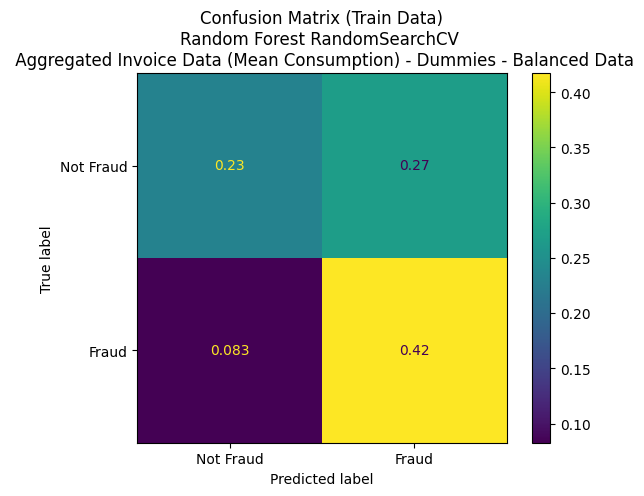

```
Model performance for
 Random Forest RandomSearchCV - Aggregated Invoice Data (Mean Consumption) - Dummies - Balanced Data:
---------------
* Test Data F1 Score:  0.1578
* Test Data ROC AUC:   0.6406
* Test Data MCC:       0.1334
* Test Data Accuracy:  0.4834
* Test Data Precision: 0.0873
```


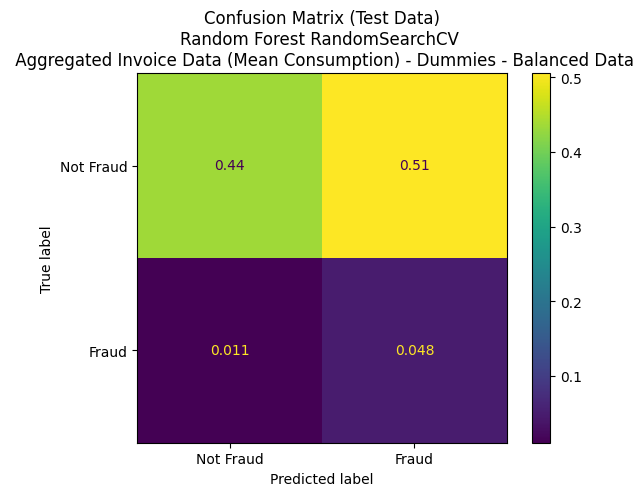

In [12]:
import metrics_plot_functions as mep

mep.print_metric_stats(
    title= f"{model_name} - {model_details}",
    train_or_test="Train Data",
    actual_vals=y_train_resampled,
    predicted_vals=y_train_pred,
    )

mep.output_confusion_matrix(
    train_or_test="Train Data",
    actual_vals=y_train_resampled,
    predicted_vals=y_train_pred,
    display_labels=["Not Fraud", "Fraud"],
    title=f"{model_name} \n {model_details}",
)

print("========================")
#print(timestamp_for_filename)

mep.print_metric_stats(
    title= f"{model_name} - {model_details}",
    train_or_test="Test Data",
    actual_vals=y_test,
    predicted_vals=y_test_pred)

mep.output_confusion_matrix(
    train_or_test="Test Data",
    actual_vals=y_test,
    predicted_vals=y_test_pred,
    display_labels=["Not Fraud", "Fraud"],
    title=f"{model_name} \n {model_details}",
)